In [1]:
import numpy as np
import cv2 as cv
from collections import defaultdict
import matplotlib.pyplot as plt
import math
%matplotlib inline

from view_sampler import ViewSampler, CameraConfig, create_viewer
from manipulated_object import ObjectPosition
from utils.orient import OrientUtils
from evaluate.evaluator import Evaluator
from evaluate.eval_funcs import calculate_penalty, generate_positions
import loss_funcs
from utils.image import ImageUtils
from tqdm.auto import tqdm

import config


# Definitions and Initializations

In [2]:
INIT_LOCATION = config.OBJ_LOCATION
OBJECTS = config.OBJECT_NAMES
ZFAR = 5
LOSS_FUNCTIONS = [config.create_loss_func(loss) for loss in config.LOSS_NAMES]
cam_config = config.CAMERA_CONFIG


In [3]:
def get_views(viewer: ViewSampler, pos1: ObjectPosition, pos2: ObjectPosition, depth: bool) -> tuple[np.ndarray, np.ndarray]:
    img1, _ = viewer.get_view_cropped(pos1, depth=depth)
    img2, _ = viewer.get_view_cropped(pos2, depth=depth)
    return img1, img2

In [4]:
def calculate_penalty2(depth_viewer: ViewSampler, num_samples: int, location:tuple[float,float,float], seed: int = None) -> float:
    # positions1 = generate_positions(num_samples, location, seed)
    # positions2 = generate_positions(num_samples, location, seed+1)
    orients = OrientUtils.generate_uniform(num_samples)
    positions1 = [ObjectPosition(orient, location) for orient in orients]

    total = 0
    count = 0
    losses = []
    for pos1 in positions1:
        depth1, _ = depth_viewer.get_view_cropped(pos1, depth=True)
        # depth2, _ = depth_viewer.get_view_cropped(pos2, depth=True)
        # pad_shape = np.maximum(depth1.shape, depth2.shape)
        # depth1 = ImageUtils.pad_to_shape(depth1, pad_shape, pad_value=0)
        # depth2 = ImageUtils.pad_to_shape(depth2, pad_shape, pad_value=0)
        mask = (depth1 > 0)
        max = np.max(depth1[mask])
        min = np.min(depth1[mask])
        # print(f"max={max}; min={min}")
        # total += np.sum(np.abs(depth1[both] - depth2[both]))
        # count += np.sum(both)
        # if np.sum(both) == 0:
        #     losses.append(0)
        #     continue
        losses.append(max-min)

    # penalty = total / count
    # print(losses)
    # penalty = np.max(losses)
    return losses



# N = 1000
# seed = 0
# penalties = {}

# for obj_name in tqdm(OBJECTS):
#     total = 0
#     count = 0
#     penalties[obj_name] = []
#     with create_viewer(obj_name, cam_config) as viewer:
#         print(f"############### {obj_name} ###############")
#         penalties[obj_name] = calculate_penalty2(viewer, N, config.OBJ_LOCATION, seed)
#         print(f"penalty[{obj_name}]={np.max(penalties[obj_name])}")
#         dist_list = np.asanyarray(penalties[obj_name])
#         print(f"Mean: {np.mean(dist_list)}")
#         print(f"Median: {np.median(dist_list)}")
#         print(f"Max: {np.max(dist_list)}")
#         print(f"Min: {np.min(dist_list)}")

# print(penalties)

In [5]:


def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        plt.figure()
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    for i in range(len(col_labels)):
        for j in range(len(row_labels)):
            text = ax.text(j, i, round(data[i, j],2),
                        ha="center", va="center", color="w")
            
    return im, cbar


# Experiments

## Test XorDiff as function of object rotation

In [6]:
# generate n+1 orientations, each is made by adding a delta to the previous

n = 24

init_pos = np.array([0,0,0.3])
uni_orients = [list(init_pos)]

q = np.array([0, 1, 0])
delta = np.linspace(0, np.pi/2, num=n+1)

for i in range(n):
    uni_orients.append(list(init_pos + delta[i+1]*q))

# uni_orients = OrientUtils.generate_random(250)
uni_positions = [ObjectPosition(orient, INIT_LOCATION) for orient in uni_orients]
len(uni_positions)

25

/home/guycoh/RoboticsAndAI/Robotics-Proj/simulator.py:38: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  return ObjectPosition.from_object(self._object)


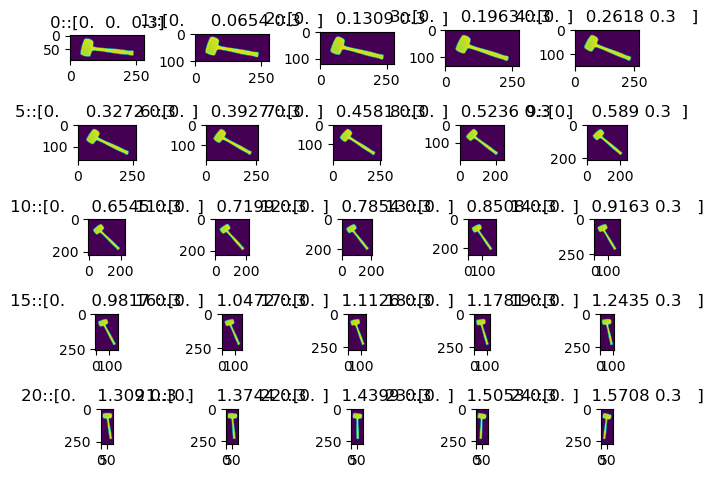

In [7]:
# choose an object and show the orientations

object_name = 'hammer'

with create_viewer(object_name, config.CAMERA_CONFIG, True) as viewer:
    nrows, ncols = (5, 5)
    fig, axes = plt.subplots(nrows, ncols)
    for idx, pos in enumerate(uni_positions):
        col = idx%ncols
        row = math.floor(idx/ncols)
        ax = axes[row, col]
        render = (viewer.get_view_cropped(pos, depth=True)[0])
        # render[render == 0] = 256
        ax.imshow(render)

        # print(pos)
        ax.set_title(f"{idx}::{np.round(pos.orientation, 4)}")

    fig.tight_layout()

In [8]:
# Evaluate XorDiff 
from evaluate import eval_funcs
from itertools import product

for obj_name in ['hammer']:
# print(f"object={obj_name}")
    with create_viewer(obj_name, config.CAMERA_CONFIG, True) as viewer:
        eval_func = eval_funcs.XorDiff(config.XORDIFF_PENALTY[obj_name]/2)
        eval_results = []

        for pos1, pos2 in product(uni_positions, uni_positions):
            img1, img2 = get_views(viewer, pos1, pos2, depth=True)
            result = eval_func(img1, img2)
            eval_results.append(result)
        results = np.array(eval_results).reshape(len(uni_positions), -1)

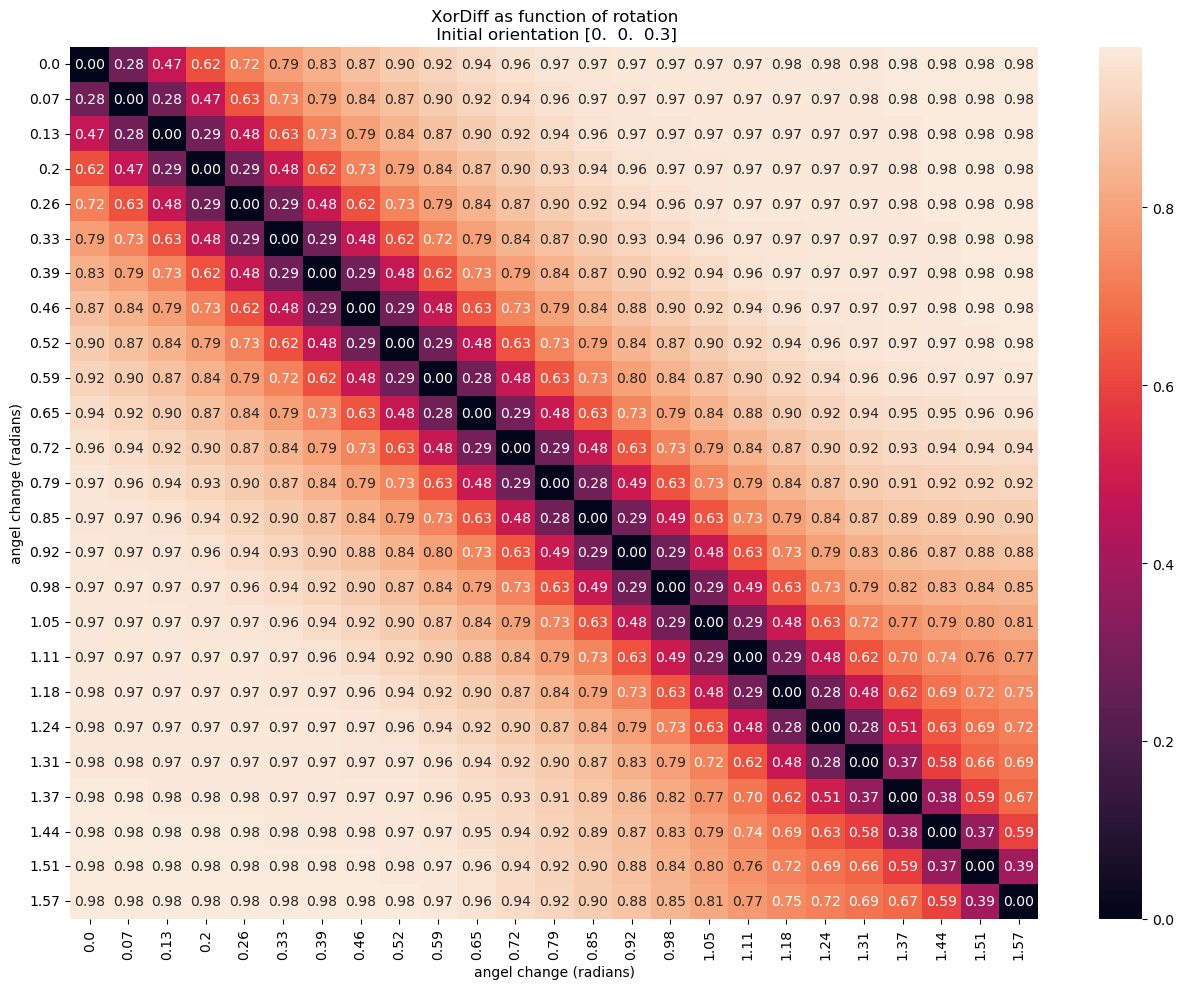

In [9]:
# plot heatmap

import seaborn as sns 
deltas = np.round(delta, 2)
fig, axes = plt.subplots(figsize=(13,10))
sns.heatmap(results, ax=axes, annot=True, fmt='.2f', xticklabels=(deltas),yticklabels=deltas)
axes.set_title(f"XorDiff as function of rotation\n Initial orientation {init_pos}")
axes.set_xlabel("angel change (radians)")
axes.set_ylabel("angel change (radians)")

axes.tick_params(axis='x', rotation=90)
axes.tick_params(axis='y', rotation=0)
axes.autoscale()
fig.tight_layout()

Text(0, 0.5, 'XorDiff value')

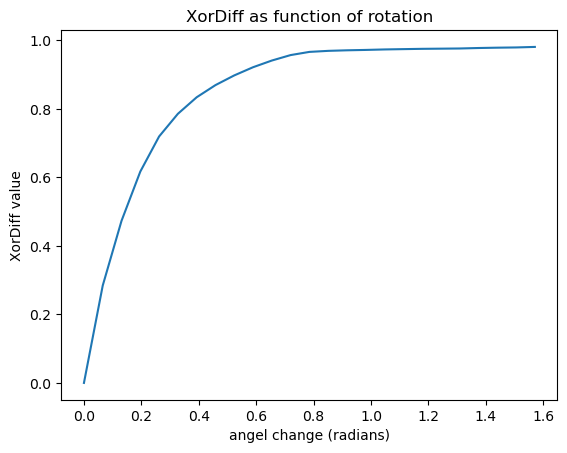

In [10]:
import seaborn as sns 
fig, ax = plt.subplots()
sns.lineplot(x=delta, y=results[0])

ax.set_title("XorDiff as function of rotation")
ax.set_xlabel("angel change (radians)")
ax.set_ylabel("XorDiff value")

## Evaluate XorDiff on random orientations

In [11]:
N = 500
positions1 = generate_positions(N, config.OBJ_LOCATION)
positions2 = generate_positions(N, config.OBJ_LOCATION)

In [12]:
from evaluate import eval_funcs
import config
import pandas as pd


eval_data = defaultdict(list)

for obj_name in tqdm(OBJECTS):
    eval_func = eval_funcs.XorDiff(config.XORDIFF_PENALTY[obj_name])
    with (create_viewer(obj_name, cam_config) as sim_viewer,
         create_viewer(obj_name, cam_config) as loss_viewer):
        for pos1, pos2 in tqdm(zip(positions1, positions2), total=N):
            img1, img2 = get_views(sim_viewer, pos1, pos2, depth=True)
            xordiff_val = eval_func(img1, img2)
           
            
            img1, img2 = get_views(loss_viewer, pos1, pos2, depth=False)
            for loss_func in LOSS_FUNCTIONS:
                eval_data['object'].append(obj_name)
                eval_data['xordiff_val'].append(xordiff_val)
                result = loss_func(img1, img2)
                eval_data['loss_val'].append(result)
                eval_data['loss_name'].append(loss_func.get_name())
            

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [13]:
df = pd.DataFrame(eval_data)
df.groupby(by=["object"])



In [ ]:
from scipy.stats import spearmanr, kendalltau
data = {}
for loss in config.LOSS_NAMES:
    count = len(OBJECTS)
    data[loss] = defaultdict(lambda:0)
    for object in OBJECTS:
        mask = df['object'] == object
        data[loss]['spearman'] += spearmanr(df[mask]['xordiff_val'].values, df[mask][loss].values).statistic / count
        data[loss]['kendalltau'] += kendalltau(df[mask]['xordiff_val'].values, df[mask][loss].values).statistic / count
        data[loss]['pearson'] += np.corrcoef(df[mask]['xordiff_val'].values, df[mask][loss].values)[0,1] / count

print(pd.DataFrame(data).transpose().to_latex('corr.lyx', float_format="%.2f"))
# correlations = {}

# # spearmanr correlation
# for loss_name, loss_vals in loss_results.items():
#     eval_vals = np.asanyarray(eval_results)
#     loss_vals = np.asanyarray(loss_vals)
#     correlations[loss_name] = {"spearman":spearmanr(eval_vals, loss_vals).statistic, "kendall":kendalltau(eval_vals, loss_vals).statistic}
#     print(f"{loss_name}: spearman: {spearmanr(eval_vals, loss_vals).statistic} kendall: {kendalltau(eval_vals, loss_vals).statistic}")

In [ ]:
import seaborn as sns 
from matplotlib import pyplot as plt
%matplotlib inline
g = sns.catplot(data=eval_data, x='object', y='xordiff_val', hue='object', aspect=2)
g.set_axis_labels("Object", "XorDiff value")
g.figure.suptitle("XorDiff Distribution for Different Objects", fontsize=12, fontweight="bold")
g.figure.tight_layout()
# g.figure.savefig("XorDiff Distribution.jpg")

In [ ]:
df.head()

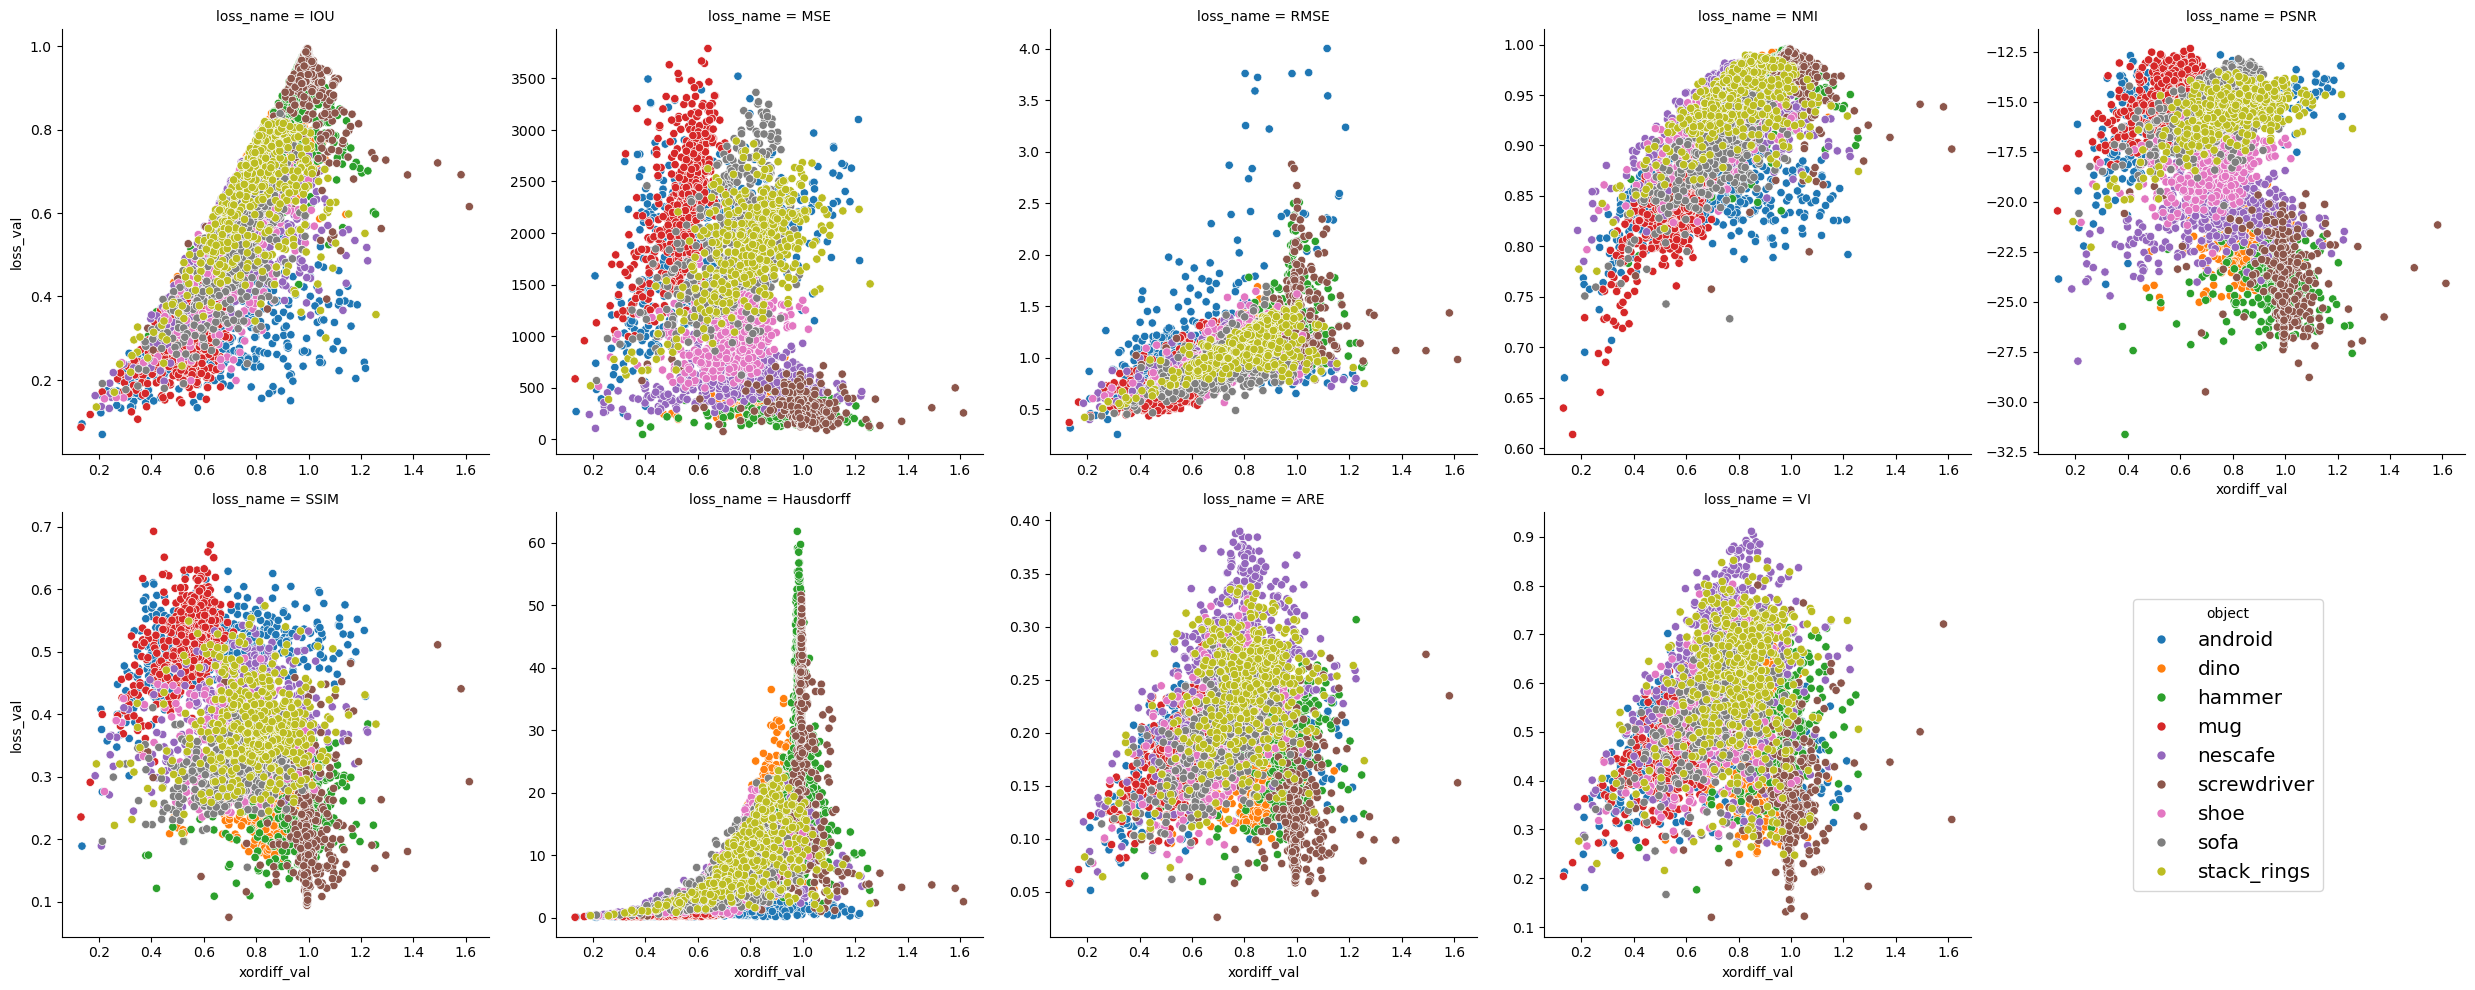

In [31]:
import seaborn as sns 
from matplotlib import pyplot as plt
%matplotlib inline
font = {"weight": "normal", "size": 10}

plt.rc("font", **font)
plt.rcParams["text.usetex"]


g = sns.relplot(data=df, x='xordiff_val', y='loss_val', col='loss_name', col_wrap=5, hue='object', facet_kws={"sharex":False, "sharey":False})

sns.move_legend(g.figure, "center", bbox_to_anchor=(0.85, 0.25), frameon=True, fontsize='x-large')

# plt.cla()
# fig, axes = plt.subplots(2, 5, sharex=False, figsize=(20, 10))


# for i, (loss_name) in enumerate(config.LOSS_NAMES):
#     ax = axes[i // 5, i % 5]
#     ax.set_xlabel("Eval Error", fontsize=12)
#     ax.set_ylabel(loss_name, fontsize=12)
#     # ax.xticks()

#     ax.set_title(f"{loss_name} Objective Function as function of XorDiff", fontweight="bold")

#     sns.scatterplot(data=df, x='xordiff_val', y=loss_name, hue='object', ax=ax, s=15, alpha=0.9,legend=False)
    
# sns.jointplot(data=df, x='xordiff_val', y='IOU', hue='object', kind='scatter', s=15)

fig.tight_layout()
# g.figure.savefig("lossesVSxordiff.jpeg")
plt.show()

In [ ]:
# from evaluate import eval_funcs

# eval_func = eval_funcs.XorDiff(0.1)
# eval_results = []

# for obj_name in tqdm(OBJECTS):
#     with create_viewer(obj_name, cam_config) as sim_viewer:
#         for pos1, pos2 in tqdm(zip(positions1, positions2), total=N):
#             img1, img2 = get_views(sim_viewer, pos1, pos2, depth=True)
#             result = eval_func(img1, img2)
#             eval_results.append(result)

In [ ]:
# loss_results = defaultdict(list)

# for obj_name in tqdm(OBJECTS):
#     with create_viewer(obj_name, cam_config) as sim_viewer:
#         for pos1, pos2 in tqdm(zip(positions1, positions2), total=N):
#             img1, img2 = get_views(sim_viewer, pos1, pos2, depth=False)
#             for loss_func in LOSS_FUNCTIONS:
#                 result = loss_func(img1, img2)
#                 loss_results[loss_func.get_name()].append(result)

In [ ]:
# for k, loss_vals in loss_results.items():
#     eval_vals = np.asanyarray(eval_results)
#     loss_vals = np.asanyarray(loss_vals)
#     print(k, np.corrcoef(eval_vals, loss_vals)[0, 1])

In [ ]:
# from matplotlib import pyplot as plt
# %matplotlib inline

# font = {"weight": "normal", "size": 10}

# plt.rc("font", **font)
# plt.rcParams["text.usetex"] = False

# plt.cla()
# fig, axes = plt.subplots(4, 3, sharex=False, figsize=(20, 20))

# for i, (loss, values) in enumerate(loss_results.items()):
#     ax = axes[i // 3, i % 3]
#     ax.set_xlabel("Eval Error")
#     ax.set_ylabel(loss)
#     ax.set_title(f"{loss} Objective Function", fontweight="bold")

#     x = eval_results
#     y = np.polyval(np.polyfit(x, values, 1), x)

#     ax.plot(x, values, ".", label=loss, markersize=6)
#     ax.plot(x, y, ":", linewidth=5)

In [ ]:
from algs.algorithm import RunConfig
from algs.uniform_sampling import UniformSampling
from evaluate import eval_funcs

run_config = RunConfig(max_time=1000, silent=True)

eval_positions = generate_positions(100)

results = defaultdict(lambda: defaultdict(list))

SELECTED_LOSSES = [
    loss_funcs.IOU(),
    loss_funcs.RMSE(),
    loss_funcs.WeightedSum(loss_funcs.IOU(), loss_funcs.RMSE()),
    loss_funcs.NMI(50),
    loss_funcs.Hausdorff(),
]

LOSS_NAMES = [l.get_name() for l in SELECTED_LOSSES]

for obj_name in tqdm(OBJECTS):
    with create_viewer(obj_name, True) as sim_viewer, create_viewer(obj_name, False) as world_viewer:
        for loss_func, loss_name in zip(SELECTED_LOSSES, LOSS_NAMES):
            alg = UniformSampling(sim_viewer, loss_func=loss_func, num_samples=512, randomized=False)
            evaluator = Evaluator(world_viewer, sim_viewer, eval_func=eval_funcs.XorDiff(0.1))
            losses = evaluator.evaluate(alg, run_config, eval_positions)
            results[obj_name][loss_name].extend(losses)

In [ ]:
from utils.io import save_pickle

res_dict = dict()

for k, v in results.items():
    res_dict[k] = dict(v)

#save_pickle("plots/loss_eval_results.pkl", results)

In [ ]:
from matplotlib import pyplot as plt

font = {"weight": "bold", "size": 10}

plt.rc("font", **font)

fig, axes = plt.subplots(3, 3, sharex=False, figsize=(30, 30))

for i, object_name in enumerate(OBJECTS):
    ax = axes[i // 3, i % 3]
    ax.set_title(object_name.upper(), fontweight="bold", fontsize=15)

    ax.boxplot(results[object_name].values(), labels=LOSS_NAMES, sym="", patch_artist=False, autorange=True)
    #ax.set_ylabel("Eval Error")

In [ ]:
from matplotlib import pyplot as plt

font = {"weight": "bold", "size": 10}

plt.rc("font", **font)

labels = [l.get_name() for l in SELECTED_LOSSES]

fig, axes = plt.subplots(3, 3, sharex=False, figsize=(30, 30))

medianprops = dict(linestyle=None, linewidth=0)
whiskerprops = dict(linewidth=0)
capprops = dict(linewidth=0)

for i, object_name in enumerate(OBJECTS):
    ax = axes[i // 3, i % 3]
    ax.set_title(object_name.upper(), fontweight="bold", fontsize=15)
    bp = ax.boxplot(
        results[object_name].values(),
        widths=0.1,
        sym="",
        patch_artist=True,
        #whis=[5, 95],
        #bootstrap=10000,
        medianprops=medianprops,
        whiskerprops=whiskerprops,
        capprops=capprops,
    )

    violin = ax.violinplot(results[object_name].values(), showmeans=False)
    ax.set_xticks([y + 1 for y in range(len(labels))], labels=LOSS_NAMES)